colors.jpg
polar_colors.txt


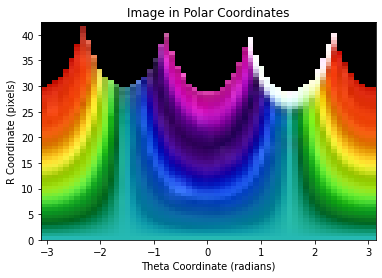

polar_colors.txt
['Position (r', ' theta): (0.0', ' -3.108271657711546)', ' Color: #26b9b3\n']
['Position (r', ' theta): (0.7190916418846246', ' -3.108271657711546)', ' Color: #1ba892\n']
['Position (r', ' theta): (1.4381832837692492', ' -3.108271657711546)', ' Color: #0d946d\n']
['Position (r', ' theta): (2.1572749256538737', ' -3.108271657711546)', ' Color: #017c46\n']
['Position (r', ' theta): (2.8763665675384984', ' -3.108271657711546)', ' Color: #006722\n']
['Position (r', ' theta): (3.595458209423123', ' -3.108271657711546)', ' Color: #08721f\n']
['Position (r', ' theta): (4.314549851307747', ' -3.108271657711546)', ' Color: #0d8421\n']
['Position (r', ' theta): (5.0336414931923725', ' -3.108271657711546)', ' Color: #0a9421\n']
['Position (r', ' theta): (5.752733135076997', ' -3.108271657711546)', ' Color: #14a622\n']
['Position (r', ' theta): (6.471824776961621', ' -3.108271657711546)', ' Color: #2cbf2b\n']
['Position (r', ' theta): (7.190916418846246', ' -3.108271657711546)', '

['Position (r', ' theta): (15.820016121461741', ' -0.24816426101432265)', ' Color: #440783\n']
['Position (r', ' theta): (16.539107763346365', ' -0.24816426101432265)', ' Color: #3d0373\n']
['Position (r', ' theta): (17.25819940523099', ' -0.24816426101432265)', ' Color: #38036a\n']
['Position (r', ' theta): (17.977291047115614', ' -0.24816426101432265)', ' Color: #31015f\n']
['Position (r', ' theta): (18.696382689000238', ' -0.24816426101432265)', ' Color: #2c0057\n']
['Position (r', ' theta): (19.415474330884866', ' -0.24816426101432265)', ' Color: #330060\n']
['Position (r', ' theta): (20.13456597276949', ' -0.24816426101432265)', ' Color: #3c016b\n']
['Position (r', ' theta): (20.853657614654114', ' -0.24816426101432265)', ' Color: #450277\n']
['Position (r', ' theta): (21.57274925653874', ' -0.24816426101432265)', ' Color: #4f0081\n']
['Position (r', ' theta): (22.291840898423363', ' -0.24816426101432265)', ' Color: #64018f\n']
['Position (r', ' theta): (23.010932540307987', ' -0.

In [50]:
from os import environ
import numpy as np
import scipy as sp
import skimage.io as ski
from PIL import Image
import matplotlib.pyplot as plt

def main():

    input_file = environ.get('input', 'colors.jpg')
    
    
    #args = sys.argv[1:]
    #print(args)
    ## Offsetting the sysargs by 3 because there is tmp garbage
    ## loaded in, if running from command line with specified
    ## input files, this will grab it
    #if len(args) > 2:
    #    input_file=args[1]
        

    output_file = 'polar_' + input_file.split('.')[0] + '.txt'
    
    print(input_file)
    print(output_file)
    
    resize_image(input_file, 'input_resized.jpg', size=(60, 60))
    image = Image.open('input_resized.jpg')
    image = image.convert('RGB')
    data = np.array(image)
    plot_polar_image(data)

    polar_grid, r_i, theta_i = reproject_image_into_polar(data, origin=None)
    reshaped_data = reshape_polar_matrix_y(polar_grid, r_i, theta_i)
    write_to_file(reshaped_data, output_file)
    parse_data(output_file)
    # file_path = 'polar_image_data.txt'
    # r, theta, colors = parse_data(file_path)
    # plot_polar(r, theta, colors)
    # 
def resize_image(input_path, output_path, size=(60, 60)):
    # Open an image file
    with Image.open(input_path) as img:
        # Resize the image
        img = img.resize(size)  # ANTIALIAS is a high-quality downsampling filter

        # Save the resized image
        img.save(output_path)

# Example usage
# resize_image('path_to_your_original_image.jpg', 'path_to_resized_image.jpg')
def plot_directional_intensity(data, origin=None):
    """Makes a cicular histogram showing average intensity binned by direction
    from "origin" for each band in "data" (a 3D numpy array). "origin" defaults
    to the center of the image."""
   

def reproject_image_into_polar(data, origin=None):
    """Reprojects a 3D numpy array ("data") into a polar coordinate system.
    "origin" is a tuple of (x0, y0) and defaults to the center of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin = (nx//2, ny//2)

    # Determine that the min and max r and theta coords will be...
    x, y = index_coords(data, origin=origin)
    r, theta = cart2polar(x, y)

    # Make a regular (in polar space) grid based on the min and max r & theta
    r_i = np.linspace(r.min(), r.max(), nx)
    theta_i = np.linspace(theta.min(), theta.max(), ny)
    theta_grid, r_grid = np.meshgrid(theta_i, r_i)

    # Project the r and theta grid back into pixel coordinates
    xi, yi = polar2cart(r_grid, theta_grid)
    xi += origin[0] # We need to shift the origin back to 
    yi += origin[1] # back to the lower-left corner...
    xi, yi = xi.flatten(), yi.flatten()
    coords = np.vstack((xi, yi)) # (map_coordinates requires a 2xn array)

    # Reproject each band individually and the restack
    # (uses less memory than reprojection the 3-dimensional array in one step)
    bands = []
    for band in data.T:
        zi = sp.ndimage.map_coordinates(band, coords, order=1)
        bands.append(zi.reshape((nx, ny)))
    output = np.dstack(bands)
    return output, r_i, theta_i


def plot_polar_image(data, origin=None):
    """Plots an image reprojected into polar coordinages with the origin
    at "origin" (a tuple of (x0, y0), defaults to the center of the image)"""
    polar_grid, r, theta = reproject_image_into_polar(data, origin)
    plt.figure()
    plt.imshow(polar_grid, extent=(theta.min(), theta.max(), r.max(), r.min()))
    plt.axis('auto')
    plt.ylim(plt.ylim()[::-1])
    plt.xlabel('Theta Coordinate (radians)')
    plt.ylabel('R Coordinate (pixels)')
    plt.title('Image in Polar Coordinates')
    plt.show()

def index_coords(data, origin=None):
    """Creates x & y coords for the indicies in a numpy array "data".
    "origin" defaults to the center of the image. Specify origin=(0,0)
    to set the origin to the lower left corner of the image."""
    ny, nx = data.shape[:2]
    if origin is None:
        origin_x, origin_y = nx // 2, ny // 2
    else:
        origin_x, origin_y = origin
    x, y = np.meshgrid(np.arange(nx), np.arange(ny))
    x -= origin_x
    y -= origin_y
    return x, y

def cart2polar(x, y):
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return r, theta

def polar2cart(r, theta):
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return x, y

def reshape_polar_matrix_x(polar_grid, r_i, theta_i):
    # Flatten the polar_grid to iterate over each pixel
    height, width, _ = polar_grid.shape
    reshaped_data = []
    
    for i in range(height):
        for j in range(width):
            # Calculate the specific r and theta for the current pixel
            r = r_i[i]
            theta = theta_i[j]
            color = polar_grid[i, j, :].astype(int)  # Assuming RGB colors
            reshaped_data.append(((r, theta), tuple(color)))
    
    return reshaped_data
def reshape_polar_matrix_y(polar_grid, r_i, theta_i):
    # Flatten the polar_grid to iterate over each pixel
    height, width, _ = polar_grid.shape
    reshaped_data = []
    
    for j in range(width):
        for i in range(height):
            # Calculate the specific r and theta for the current pixel
            r = r_i[i]
            theta = theta_i[j]
            color = polar_grid[i, j, :].astype(int)  # Assuming RGB colors
            reshaped_data.append(((r, theta), tuple(color)))
    
    return reshaped_data

def rgb_to_hex(color):
    """Convert an RGB color to hexadecimal format."""
    return '#{:02x}{:02x}{:02x}'.format(*color)

def write_to_file(reshaped_data, filename="polar_image_data.txt"):
    print(filename)
    with open(filename, 'w') as file:
        for item in reshaped_data:
            position, color = item
            hex_color = rgb_to_hex(color)  # Convert RGB to Hex
            file.write(f"Position (r, theta): {position}, Color: {hex_color}\n")

def parse_data(file_path):
    r = []
    theta = []
    colors = []
    with open(file_path, 'r') as file:
        for line in file:
            if "Position" in line:
                parts = line.split(',')
                # print(parts)
               
                print(parts)
                
                # r.append(r_value)
                # theta.append(theta_value)
                # colors.append(color)
    return r, theta, colors


####export data to file in a format that could be read by C code
main()